In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import assnake

import os

In [3]:
matson = assnake.Dataset('Matson_2019')
samples = matson.sample_sets['sra']

In [7]:
meta = pd.read_csv('../METADATA/meta_human_wgs.tsv', sep = '\t', index_col = 0)
# meta

In [8]:
pathabundance_wc = '{fs_prefix}/{df}/humann2__v2.9__test1/MATSON_custom_db__bypass/{df_sample}/{preproc}/{df_sample}_pathabundance__cpm.tsv'

path_ab = []
for s in samples.to_dict(orient = 'records'):
    pa_loc = pathabundance_wc.format(**s)
    if os.path.isfile(pa_loc):
        pa_pd = pd.read_csv(pa_loc, sep = '\t', index_col = 0)
        path_ab.append(pa_pd)
path_ab = pd.concat(path_ab, axis=1, sort=False)

# Filter
path_ab.columns = path_ab.columns.str.replace('_Abundance', '')
path_ab = path_ab.loc[path_ab.index.str.contains('\|') == False]

In [9]:
rm_cols = ['UNMAPPED','UNINTEGRATED']
hm2_path = path_ab
hm2_path = hm2_path.fillna(0)
hm2_path = hm2_path.T
hm2_path = hm2_path.drop(rm_cols, axis = 1)
hm2_path.shape

(39, 126)

In [10]:
mapping = pd.read_csv('/data11/bio/databases/HUMANN2/utility_mapping/map_kegg-pwy_name.txt', sep = '\t', header= None, index_col = 0)
mapping = mapping.reindex(hm2_path.columns)
mapping = mapping.fillna('no_name')
mapping[1] = mapping.index + ' ' + mapping[1]

hm2_path = hm2_path.rename(mapping.to_dict(orient='dict')[1], axis=1)


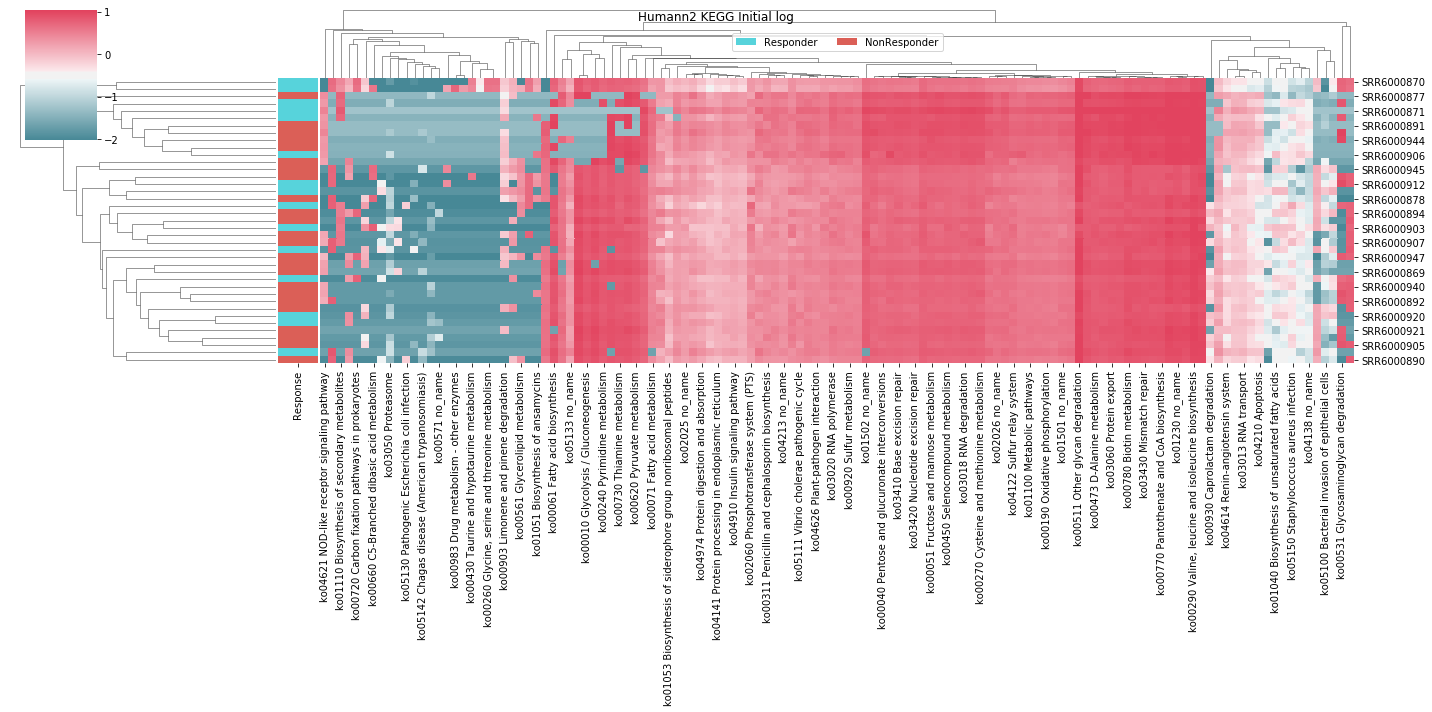

In [15]:
# hm2_path_cleaned = hm2_path.loc[:,hm2_path.sum()>0.6]
hm2_path_log = np.log(hm2_path+0.1)

resp_str = 'Response'
resp_colors, rc = prepare_row_colors(meta, resp_str)

cmap = sns.diverging_palette(h_neg=213, h_pos=6, s=72, l=53, sep=15, n=9,as_cmap = True)
g = sns.clustermap(hm2_path_log, figsize=(20,10), cmap=cmap, robust=True, 
                   row_colors = resp_colors,
                   z_score=0,
                  )
g.fig.suptitle('Humann2 KEGG Initial log') 
for label in set(meta[resp_str]):
    g.ax_col_dendrogram.bar(0, 0, color=rc[label],label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)

In [ ]:
def humann2_genefamilies_load(sample_set, database, version = 'v2.9', params = 'test1'):
    genefamilies_wc = '{fs_prefix}/{df}/humann2__v2.9__test1/MATSON_custom_db__bypass/{df_sample}/{preproc}/{df_sample}_genefamilies.tsv'

    gf_ab = []
    for s in samples.to_dict(orient = 'records'):
        gf_loc = genefamilies_wc.format(**s)
        if os.path.isfile(gf_loc):
            gf_pd = pd.read_csv(gf_loc, sep = '\t', index_col = 0)
            gf_ab.append(gf_pd)
    gf_ab = pd.concat(gf_ab, axis=1, sort=False)

    # Filter
    gf_ab.columns = gf_ab.columns.str.replace('-RPKs', '')
    gf_ab.columns = gf_ab.columns.str.replace('_Abundance', '')
    gf_ab = gf_ab.loc[gf_ab.index.str.contains('\|') == False]

In [17]:
rm_cols = ['UNMAPPED']
hm2_gf = gf_ab
hm2_gf = hm2_gf.fillna(0)
hm2_gf = hm2_gf.T
hm2_gf = hm2_gf.drop(rm_cols, axis = 1)
hm2_gf.shape

(39, 5663)

In [18]:
mapping = pd.read_csv('/data11/bio/databases/HUMANN2/utility_mapping/map_ko_name.txt', sep = '\t', header= None, index_col = 0)
mapping = mapping.reindex(hm2_gf.columns)
mapping = mapping.fillna('no_name')
mapping[1] = mapping.index + ' ' + mapping[1]

In [19]:
hm2_gf = hm2_gf.rename(mapping.to_dict(orient='dict')[1], axis=1)


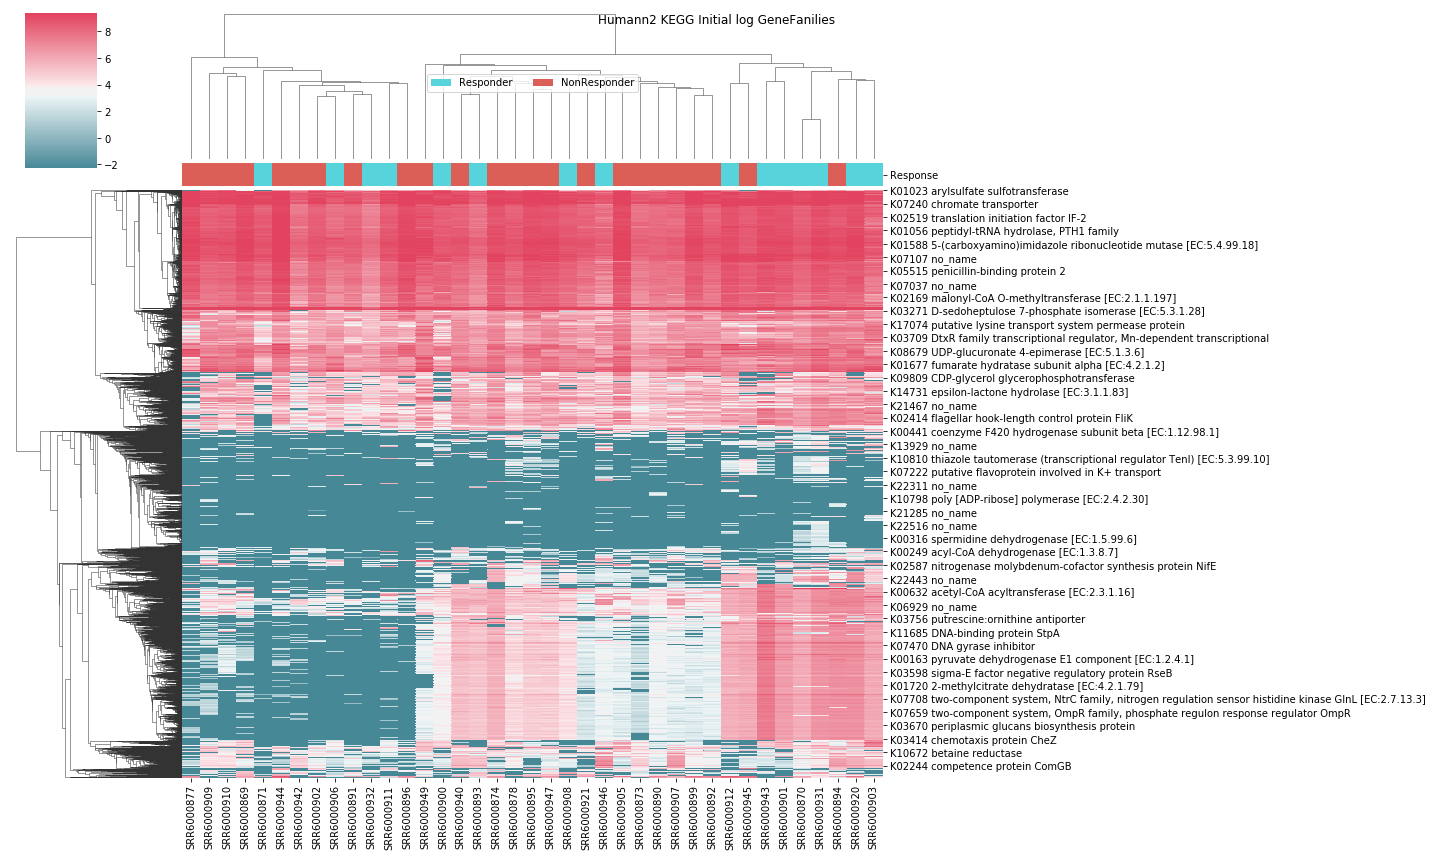

In [24]:
hm2_path_log = np.log(hm2_gf.T+0.1)

resp_str = 'Response'
resp_colors, rc = prepare_row_colors(meta, resp_str)

cmap = sns.diverging_palette(h_neg=213, h_pos=6, s=72, l=53, sep=15, n=9,as_cmap = True)
g = sns.clustermap(hm2_path_log, figsize=(20,12), cmap=cmap, robust=True, 
                   col_colors = resp_colors,
#                    z_score=0,
                  )
g.fig.suptitle('Humann2 KEGG Initial log GeneFanilies') 
for label in set(meta[resp_str]):
    g.ax_col_dendrogram.bar(0, 0, color=rc[label],label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)

In [12]:
def prepare_row_colors(meta, feature_name_str):
    pal = sns.color_palette("hls", meta[feature_name_str].unique().size)
    lut = dict(zip(map(str, meta[feature_name_str].unique()), pal))

    row_colors = pd.Series(meta[feature_name_str]).map(lut)
    feature_color = lut
    return row_colors, feature_color